# HSC Re-Run: Making Forced Photometry Light Curves from Scratch

<br>Owner: **Justin Myles** ([@jtmyles](https://github.com/LSSTScienceCollaborations/StackClub/issues/new?body=@jtmyles))
<br>Last Verified to Run: **2018-08-10**
<br>Verified Stack Release: **16.0**

This project addresses issue [#63: HSC Re-run](https://github.com/LSSTScienceCollaborations/StackClub/issues/63)

This notebook demonstrates the pipeline described in the [LSST Science Piplines data processing tutorial](https://pipelines.lsst.io/), from ingesting images (using the [obs_subaru](https://github.com/lsst/obs_subaru) package) through image processing, coaddition, source detection and object measurement all the way through to measuring forced photometry light curves in a small patch of the HSC sky (in the [ci_hsc](https://github.com/lsst/ci_hsc/) repository). 

### Learning Objectives:
After working through and studying this notebook you should be able to understand how to use the DRP pipeline from image visualization through to a forced photometry light curve. Specific learning objectives include: 
   1. [Configuring](https://pipelines.lsst.io/v/w-2018-12/modules/lsst.pipe.base/command-line-task-config-howto.html) and executing pipeline tasks in python as well as on the command line.
   2. The sequence of steps involved in the DRP pipeline.
   
Other techniques that are demonstrated, but not emphasized, in this notebook are
   1. Using the `butler` to fetch data
   2. Visualizing data with the LSST Stack

### Logistics
This notebook is intended to be runnable on `lsst-lspdev.ncsa.illinois.edu` from a local git clone of https://github.com/LSSTScienceCollaborations/StackClub.


## Set Up

In [ ]:
# todo: nb will point to processCcd.ipynb notebook on how to unpack a CL task
# todo: and will actually unpack processCcd, but not other tasks
# todo: then will make a few plots showing result of what we can do with processed images 

In [4]:
import os
import re
import sys
import glob
import numpy as np
import pandas as pd
import astropy.io.fits as fitsio
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
%matplotlib inline

import eups.setupcmd
import lsst.daf.persistence as dafPersist

## Pipeline Preview

Before we unpack the pipeline described in the [LSST Science Piplines data processing tutorial](https://pipelines.lsst.io/), let's look at the complete set of command line tasks assembled into an end-to-end data reduction script.

In [5]:
! cat Re-RunHSC.sh

: 'HSC Re-Run: Making Forced Photometry Light Curves from Scratch
Owner: **Justin Myles** (@jtmyles)
Last Verified to Run: **2018-09-13**
Verified Stack Release: **16.0**

This project addresses issue #63: HSC Re-run

This shell script runs the command-line tasks from the tutorial at pipelines.lsst.io for analysis
from raw images through source detection and forced photometry measurements. It is an intermediate
step toward the end-goal of making a forced photometry lightcurve in the notebook at
StackClub/ImageProcessing/Re-RunHSC.ipynb

Running this script may take several hours on lsst-lspdev.

Recommended to run with 
$ bash Re-RunHSC.sh > output.txt
'


# Setup the LSST Stack
source /opt/lsst/software/stack/loadLSST.bash
eups list lsst_distrib
setup lsst_distrib


# I. Setting up the Butler data repository
date
echo "Re-RunHSC INFO: set up the Butler"

setup -j -r /project/shared/data/ci_hsc
DATADIR="/home/$USER/DATA"
mkdir -p "$DATADIR"

# A Butler needs a *mapper* file "to find an

We'll come back to each step in turn throughout the rest of this notebook.

## Part I: Interacting with data. Introduction to the Butler
https://pipelines.lsst.io/getting-started/data-setup.html

Part I runs the following command-line tasks
```
eups list lsst_distrib
setup -j -r /home/jmyles/repositories/ci_hsc
echo "lsst.obs.hsc.HscMapper" > /home/jmyles/DATA/_mapper
ingestImages.py /home/jmyles/DATA /home/jmyles/repositories/ci_hsc/raw/*.fits --mode=link
ln -s /home/jmyles/repositories/ci_hsc/CALIB/ /home/jmyles/DATA/CALIB
installTransmissionCurves.py /home/jmyles/DATA
mkdir -p /home/jmyles/DATA/ref_cats
ln -s /home/jmyles/repositories/ci_hsc/ps1_pv3_3pi_20170110 /home/jmyles/DATA/ref_cats/ps1_pv3_3pi_20170110
```

In [6]:
HOME = os.environ['HOME']
DATAREPO = "{}/repositories/ci_hsc/".format(HOME)
DATADIR = "{}/DATA/".format(HOME)
CI_HSC = "/project/shared/data/ci_hsc/"
os.system("mkdir -p {}".format(DATADIR));

In [ ]:
#!setup -j -r /home/jmyles/repositories/ci_hsc

setup = eups.setupcmd.EupsSetup(["-j","-r", DATAREPO])
status = setup.run()
print('setup exited with status {}'.format(status))

A Butler needs a *mapper* file "to find and organize data in a format specific to each camera." We write this file to the data repository so that any instantiated Butler object knows which mapper to use.

In [ ]:
with open(DATADIR + "_mapper", "w") as f:
    f.write("lsst.obs.hsc.HscMapper")

In [ ]:
# ingest script
!ingestImages.py DATADIR /home/jmyles/repositories/ci_hsc/raw/*.fits --mode=link

In [ ]:
#!installTransmissionCurves.py /home/jmyles/DATA

from lsst.obs.hsc import makeTransmissionCurves, HscMapper
from lsst.daf.persistence import Butler

butler = Butler(outputs={'root': datadir, 'mode': 'rw', 'mapper': HscMapper})

for start, nested in makeTransmissionCurves.getFilterTransmission().items():
    for name, curve in nested.items():
        if curve is not None:
            butler.put(curve, "transmission_filter", filter=name)
for start, nested in makeTransmissionCurves.getSensorTransmission().items():
    for ccd, curve in nested.items():
        if curve is not None:
            butler.put(curve, "transmission_sensor", ccd=ccd)
for start, curve in makeTransmissionCurves.getOpticsTransmission().items():
    if curve is not None:
        butler.put(curve, "transmission_optics")
for start, curve in makeTransmissionCurves.getAtmosphereTransmission().items():
    if curve is not None:
        butler.put(curve, "transmission_atmosphere")

In [ ]:
# ingest calibration images into Butler repo
os.system("ln -s {} {}".format(datarepo + "CALIB/", datadir + "CALIB"))

# ingest reference catalog into Butler repo
os.system("mkdir -p {}".format(DATADIR + "ref_cats"))
os.system("ln -s {}ps1_pv3_3pi_20170110 {}ref_cats/ps1_pv3_3pi_20170110".format(DATAREPO, DATADIR))

# Part 2: Calibrating single frames
https://pipelines.lsst.io/getting-started/processccd.html

In [ ]:
"""
!processCcd.py DATA --rerun processCcdOutputs --id
# all cl tasks write output datasets to a Butler repo
# --rerun configured to write to processCcdOutputs
# other option is --output
"""

In [ ]:
!which processCcd.py
"""
processCcd.py
from lsst.pipe.tasks.processCcd import ProcessCcdTask

ProcessCcdTask.parseAndRun()
"""

In [ ]:
# show source of lsst.pipe.tasks.processCcd
# emacs /opt/lsst/software/stack/stack/miniconda3-4.3.21-10a4fa6/Linux64/pipe_tasks/16.0+1/python/lsst/pipe/tasks/processCcd.py


In [ ]:
from lsst.pipe.tasks.processCcd import ProcessCcdTask, ProcessCcdConfig
processCcdTaskInstance = ProcessCcdTask(butler=butler)

In [ ]:
from stackclub import where_is
where_is(processCcdTaskInstance, in_the="source")

In [ ]:
processCcdConfig = ProcessCcdConfig()

In [ ]:
"""
# review what data will be processed
!processCcd.py DATA --rerun processCcdOutputs --id --show data
# id allows you to select data by data ID
# unspecified id selects all raw data
# example IDs: raw, filter, visit, ccd, field
# show data turns on dry-run mode
"""

In [ ]:
#!which processCcd.py

# Part 3: Displaying exposures and source tables output by processCcd.py
https://pipelines.lsst.io/getting-started/display.html

This part of the tutorial is omitted.

# Part 4: Coadding images
https://pipelines.lsst.io/getting-started/coaddition.html

* A sky map is a tiling of the celestial sphere. It is composed of one or more tracts.
* A tract is composed of one or more overlapping patches. Each tract has a WCS.

the configuration field specifies the WCS Projection, e.g.
    - STG: stereographic projection
    - MOL: Molleweide's projection
    - TAN: tangent-plane projection

In [ ]:
"""# make a discrete sky map that covers the exposures that have already been processed
!makeDiscreteSkyMap.py DATA --id --rerun processCcdOutputs:coadd --config skyMap.projection="TAN"

"""

# Part 6: Multi-band catalog analysis
https://pipelines.lsst.io/getting-started/multiband-analysis.html

We now turn to making plots of the photometry we've done. To start, we access the sources identified from the coadd images.

In [7]:
butler_coadd = dafPersist.Butler(inputs=DATADIR + 'rerun/coaddForcedPhot/')

Grab their measured forced photometry.

In [8]:
rSources = butler_coadd.get('deepCoadd_forced_src', {'filter': 'HSC-R', 'tract': 0, 'patch': '1,1'})
iSources = butler_coadd.get('deepCoadd_forced_src', {'filter': 'HSC-I', 'tract': 0, 'patch': '1,1'})
print('{} sources with forced photometry measured from coadds'.format(len(rSources)))

6800 sources with forced photometry measured from coadds


Discard sources with negative fluxes and convert fluxes to magnitudes.

In [9]:
rCoaddCalib = butler_coadd.get('deepCoadd_calexp_calib',  {'filter': 'HSC-R', 'tract': 0, 'patch': '1,1'})
iCoaddCalib = butler_coadd.get('deepCoadd_calexp_calib',  {'filter': 'HSC-I', 'tract': 0, 'patch': '1,1'})

rCoaddCalib.setThrowOnNegativeFlux(False)
iCoaddCalib.setThrowOnNegativeFlux(False)

rMags_coadd = rCoaddCalib.getMagnitude(rSources['base_PsfFlux_flux'])
iMags_coadd = iCoaddCalib.getMagnitude(iSources['base_PsfFlux_flux'])

Make selection from catalog for stars only.

In [10]:
deblended = rSources['deblend_nChild'] == 0

refTable = butler_coadd.get('deepCoadd_ref', {'filter': 'HSC-R^HSC-I', 'tract': 0, 'patch': '1,1'})
inInnerRegions = refTable['detect_isPatchInner'] & refTable['detect_isTractInner'] # define inner regions
isSkyObject = refTable['merge_peak_sky'] # reject sky objects
isPrimary = refTable['detect_isPrimary']

isStellar = iSources['base_ClassificationExtendedness_value'] < 1.
isGoodFlux = ~iSources['base_PsfFlux_flag']
selected = isPrimary & isStellar & isGoodFlux

Make color-magnitude diagram.

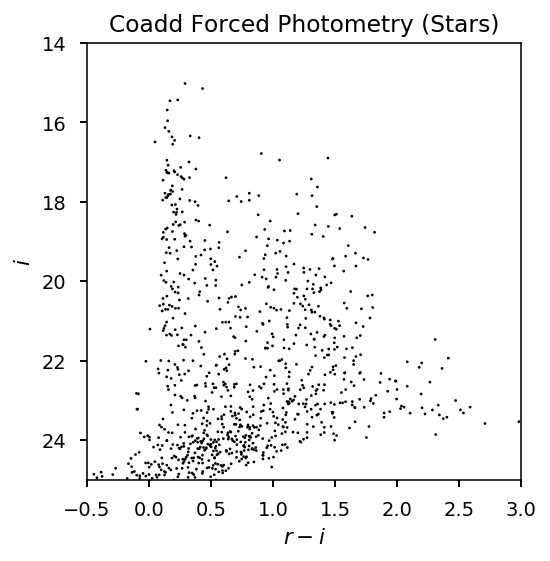

In [11]:
plt.style.use('seaborn-notebook')
plt.figure(1, figsize=(4, 4), dpi=140)
plt.title('Coadd Forced Photometry (Stars)')
plt.scatter(rMags_coadd[selected] - iMags_coadd[selected],
            iMags_coadd[selected],
            edgecolors='None', s=2, c='k')

plt.xlim(-0.5, 3)
plt.ylim(25, 14)
plt.xlabel('$r-i$')
plt.ylabel('$i$')
plt.subplots_adjust(left=0.125, bottom=0.1)
plt.show()

Instantiate Butler with forced photometry measured for individual exposures

In [12]:
butler_ccd = dafPersist.Butler(inputs=DATADIR + 'rerun/ccdForcedPhot/')

In order to associate individual visits with the MJD of the exposure, we go back to the raw images stored in the Butler repository. This may be replaceable with cleaner code that takes advantage of some Butler feature that accomplishes the same goal.

In [13]:
# associate each visit ID with an MJD
# store in lookup hashtable
visit_to_mjd = {}   

raw_files = glob.glob(CI_HSC + 'raw/HSCA*.fits')

for infile in raw_files:
    visit_id = infile[len(CI_HSC) + len("raw/HSCA"):-7]
    hdulist = fitsio.open(infile)
    try:
        mjd = hdulist[1].header['MJD']
    except:
        mjd = hdulist[0].header['MJD']
    visit_to_mjd[visit_id] = mjd

Doing forced photometry on individual exposures saves the source tables in different files. Here we query the Butler for all the data and store the tables together. This may be replaceable with cleaner code that takes advantage of some Butler feature that accomplishes the same goal.

In [14]:
data_id_fields = [('filter', str), ('pointing', int), ('visit', int), 
                  ('ccd', int), ('field', str), ('dateObs', str), 
                  ('taiObs', str), ('expTime', float), ('tract', int)]

i_tables = []
r_tables = []

for line in open(DATADIR + 'data_ids.txt'):
    fields = line.split(",")
    
    data_id_dict = {data_id_fields[i][0] : data_id_fields[i][1](fields[i].split(':')[1]) for i in range(len(fields))}
    print(data_id_dict)
    
    sources = butler_ccd.get('forced_src', data_id_dict)
    source_table = sources.asAstropy().to_pandas()
    source_table['visit'] = fields[2].split(':')[1]
    # TODO : fix this
    source_table['mjd'] = [visit_to_mjd[key] if key in visit_to_mjd else 56598.2 for key in source_table['visit'] ] # this is obviously problematic

    if fields[0] == 'filter:HSC-R':
        r_tables.append(source_table)
    elif fields[0] == 'filter:HSC-I':
        i_tables.append(source_table)
    else:
        print('Failed to read filter')

{'filter': 'HSC-R', 'pointing': 533, 'visit': 903334, 'ccd': 23, 'field': 'STRIPE82L', 'dateObs': '2013-06-17', 'taiObs': '2013-06-17', 'expTime': 30.0, 'tract': 0}
{'filter': 'HSC-R', 'pointing': 533, 'visit': 903334, 'ccd': 22, 'field': 'STRIPE82L', 'dateObs': '2013-06-17', 'taiObs': '2013-06-17', 'expTime': 30.0, 'tract': 0}
{'filter': 'HSC-R', 'pointing': 533, 'visit': 903334, 'ccd': 16, 'field': 'STRIPE82L', 'dateObs': '2013-06-17', 'taiObs': '2013-06-17', 'expTime': 30.0, 'tract': 0}
{'filter': 'HSC-R', 'pointing': 533, 'visit': 903334, 'ccd': 100, 'field': 'STRIPE82L', 'dateObs': '2013-06-17', 'taiObs': '2013-06-17', 'expTime': 30.0, 'tract': 0}
{'filter': 'HSC-R', 'pointing': 533, 'visit': 903336, 'ccd': 24, 'field': 'STRIPE82L', 'dateObs': '2013-06-17', 'taiObs': '2013-06-17', 'expTime': 30.0, 'tract': 0}
{'filter': 'HSC-R', 'pointing': 533, 'visit': 903336, 'ccd': 17, 'field': 'STRIPE82L', 'dateObs': '2013-06-17', 'taiObs': '2013-06-17', 'expTime': 30.0, 'tract': 0}
{'filter'

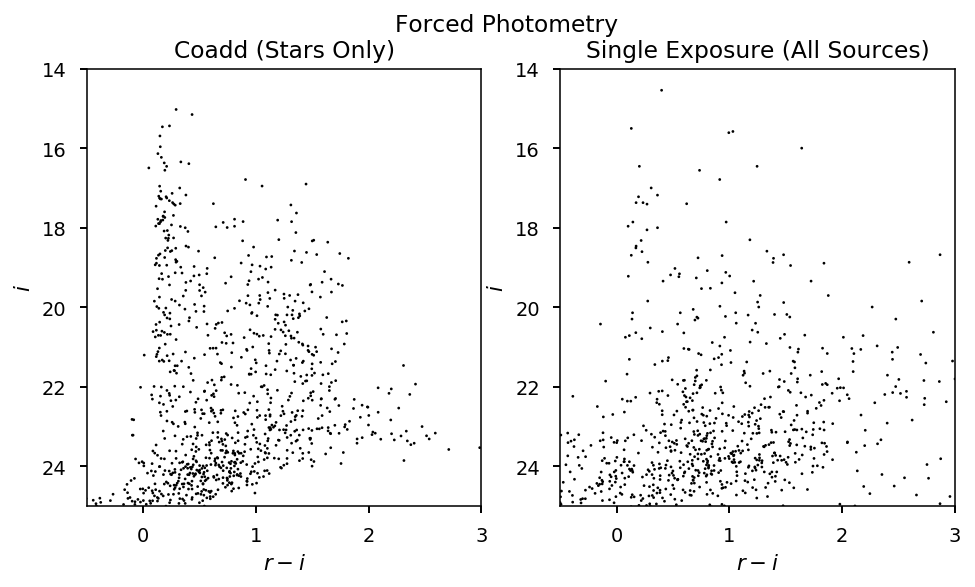

In [15]:
plt.style.use('seaborn-notebook')
fig, axarr = plt.subplots(1, 2, figsize=(8, 4), dpi=140)

fig.suptitle('Forced Photometry')

axarr[0].set_title('Coadd (Stars Only)')
axarr[0].scatter(rMags_coadd[selected] - iMags_coadd[selected],
                 iMags_coadd[selected],
                 edgecolors='None', s=2, c='k')

axarr[0].set_xlim(-0.5, 3)
axarr[0].set_ylim(25, 14)
axarr[0].set_xlabel('$r-i$')
axarr[0].set_ylabel('$i$')

# datasetRefOrType : forced_src
# see all options at
# /opt/lsst/software/stack/stack/miniconda3-4.3.21-10a4fa6/Linux64/obs_subaru/16.0+1/python/lsst/obs/hsc
iDataId = {'filter': 'HSC-I', 'pointing': 671, 'visit': 903986, 'ccd': 16, 'field': 'STRIPE82L', 'dateObs': '2013-11-02', 
           'taiObs': '2013-11-02', 'expTime': 30.0, 'tract': 0, 'patch' : '1,1'}
rDataId = {'filter': 'HSC-R', 'pointing': 533, 'visit': 903334, 'ccd': 16, 'field': 'STRIPE82L', 'dateObs': '2013-06-17', 
          'taiObs': '2013-06-17', 'expTime': 30.0, 'tract': 0, 'patch' : '1,1'}

iSources = butler_ccd.get('forced_src', iDataId)
rSources = butler_ccd.get('forced_src', rDataId)

iCcdCalib = butler_ccd.get('calexp_calib', iDataId)
rCcdCalib = butler_ccd.get('calexp_calib', rDataId)

rMags_ccd = rCcdCalib.getMagnitude(rSources['base_PsfFlux_flux'])
iMags_ccd = iCcdCalib.getMagnitude(iSources['base_PsfFlux_flux'])

axarr[1].set_title('Single Exposure (All Sources)')
plt.scatter(rMags_ccd - iMags_ccd, iMags_ccd, edgecolors='None', s=2, c='k')
axarr[1].set_xlim(-0.5, 3)
axarr[1].set_ylim(25, 14)
axarr[1].set_xlabel('$r-i$')
axarr[1].set_ylabel('$i$')
plt.subplots_adjust(left=0.125, bottom=0.1)

plt.show()

Now we concatenate the concatenate the measured sources into two tables (one for each filter). Then group by object ID to draw a five epoch light curve.

In [16]:
iSources = pd.concat(i_tables)    
rSources = pd.concat(r_tables)

iGrouped = iSources.groupby('objectId')
rGrouped = rSources.groupby('objectId')

print('{} i band objects, {} measurements'.format(len(np.unique(iSources['objectId'])), len(iSources['objectId'])))
print('{} r band objects, {} measurements'.format(len(np.unique(rSources['objectId'])), len(rSources['objectId'])))

objids = [name for name, group in iGrouped if len(group) == 5]
print('{} objects with 5 epocs'.format(len(objids)))

9742 i band objects, 30400 measurements
8321 r band objects, 32717 measurements
1769 objects with 5 epocs


Choose an object to draw a light curve.

In [20]:
obj = objids[1]
print('e.g. objectId:', obj, '(showing select rows from table)')
iSources[iSources['objectId'] == obj][['id','coord_ra','coord_dec','objectId','base_PsfFlux_flux','visit','mjd']]

e.g. objectId: 141733921084 (showing select rows from table)


,id,coord_ra,coord_dec,objectId,base_PsfFlux_flux,visit,mjd
278,776518129927848215,5.599023,-0.006443,141733921084,9120.533865,903986,56598.221156
517,776519852209734150,5.599023,-0.006443,141733921084,9886.496949,903988,56598.222126
772,776521574491620101,5.599023,-0.006443,141733921084,9071.808927,903990,56598.223046
1,776538694231261186,5.599023,-0.006443,141733921084,27701.589804,904010,56598.250471
84,776542138795032661,5.599023,-0.006443,141733921084,9585.718591,904014,56598.200000


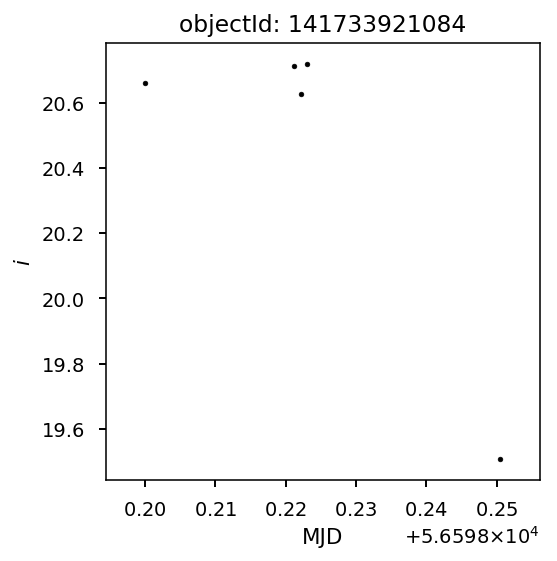

In [18]:
plt.style.use('seaborn-notebook')
plt.figure(3, figsize=(4, 4), dpi=140)
plt.title('objectId: {}'.format(obj))
plt.scatter(iSources[iSources['objectId'] == obj]['mjd'].values, 
            iCcdCalib.getMagnitude(iSources[iSources['objectId'] == obj]['base_PsfFlux_flux'].values),
            s=6, c='k')

plt.ylabel('$i$')
plt.xlabel('MJD')

plt.subplots_adjust(left=0.125, bottom=0.1)
ax = plt.gca()
ax.ticklabel_format(useOffset=56598, style='plain', axis='x', useMathText=True)
plt.show()